In [177]:
import os
from bs4 import BeautifulSoup, NavigableString

# Functions

In [5]:
def parse_nested_braces(string):
    stack = []
    results = []
    current = []

    for char in string:
        if char == '{':
            stack.append('{')
            current.append(char)
        elif char == '}' and stack:
            stack.pop()
            current.append(char)
            if not stack:  # Completed a nested structure
                results.append(''.join(current))
                current = []
        elif stack:
            current.append(char)

    return results

In [71]:
def parse_key_value_pairs(string):
    def is_key_start(index):
        # Check if the current index is the start of a key
        return string[index] == '"' and (index == 0 or string[index - 1] not in '\\')

    def find_key_end(start_index):
        # Find the end of the key (next unescaped quote)
        index = start_index + 1
        while index < len(string):
            if string[index] == '"' and string[index - 1] != '\\':
                return index
            index += 1
        return -1

    def find_value(index):
        if string[index] in '{[':
            # Handle nested structure
            opening = string[index]
            closing = '}' if opening == '{' else ']'
            depth = 1
            index += 1
            while index < len(string) and depth > 0:
                if string[index] == opening:
                    depth += 1
                elif string[index] == closing:
                    depth -= 1
                index += 1
            return index
        else:
            # Handle simple value
            in_quotes = False
            while index < len(string):
                if string[index] == '"' and (index == 0 or string[index - 1] != '\\'):
                    in_quotes = not in_quotes
                elif not in_quotes and string[index] in ',}':
                    return index
                index += 1
            return index

    results = {}
    i = 0
    while i < len(string):
        if is_key_start(i):
            key_end = find_key_end(i)
            if key_end != -1:
                key = string[i + 1:key_end]
                # Skip to the colon and the following whitespace
                i = key_end + 2
                while i < len(string) and string[i] in ' \t':
                    i += 1
                value_end = find_value(i)
                value = string[i:value_end].strip()
                results[key] = value
                i = value_end
        i += 1

    return results

In [175]:
def parse_item(pageItem):
    if pageItem['type'] == '"TITLE"':
        new_pageItem['type'] = "TITLE"
        new_pageItem['value'] = pageItem['value']
        
    if pageItem['type'] == '"IMAGE"':
        new_pageItem['type'] = "IMAGE"
        userFile = parse_key_value_pairs(pageItem['userFile'])
        url = f"https://courses.edovo.com/{userFile['contentPath'][1:-1]}"
        new_pageItem['value'] = url

    if pageItem['type'] == '"SHORT_ANSWER"':
        new_pageItem['type'] = "SHORT_ANSWER"

        question = pageItem['value']
        question = BeautifulSoup(question, 'html.parser').text
        answers = [parse_key_value_pairs(pi) for pi in parse_nested_braces(pageItem['answers'][1:-1])]

    if pageItem['type'] == '"TEXT"':
        new_pageItem['type'] = "TEXT"
        html = pageItem['value']
        html_soup = BeautifulSoup(html, 'html.parser')

        all_text = []
        for tag in html_soup.stripped_strings:
            text = ' '.join(repr(tag).strip()[1:-1].replace("\n"," ").replace("\\\\\\", "").replace("\\", "").split())
            all_text.append(text)

        html_imgs = html_soup.find_all('img')
        html_imgs_srcs = [img['src'].replace('\\"',"") for img in html_imgs if 'src' in img.attrs]
        new_pageItem['value'] = {'text': all_text, 'images': html_imgs_srcs}
        
    if pageItem['type'] == '"MULTIPLE_CHOICE"':
        new_pageItem['type'] = "MULTIPLE_CHOICE"

        question = pageItem['value']
        question = BeautifulSoup(question, 'html.parser').text

        explanation = pageItem['explanation']
        explanation = BeautifulSoup(question, 'html.parser').text

        answers = [parse_key_value_pairs(pi) for pi in parse_nested_braces(pageItem['answers'][1:-1])]    

        new_pageItem['value'] = {'question': question, 'answers': answers, 'explanation': explanation}
        
    return new_pageItem

In [182]:
def natural_sort_key(s):
    return [int(text) if text.isdigit() else text.lower() for text in re.split('([0-9]+)', s)]

# Read all files

In [184]:
root_path = '/Users/vivianamarquez/Desktop/prisoneducation/raw_html/'
all_files = []

for root, dirs, files in os.walk(root_path):
    for file in files:
        file_path = os.path.join(root, file)
        if file_path.endswith('.html'):
            all_files.append(file_path)
            
all_files.sort(key=natural_sort_key)
all_files

['/Users/vivianamarquez/Desktop/prisoneducation/raw_html/lesson_1/page_1.html',
 '/Users/vivianamarquez/Desktop/prisoneducation/raw_html/lesson_1/page_2.html',
 '/Users/vivianamarquez/Desktop/prisoneducation/raw_html/lesson_1/page_3.html',
 '/Users/vivianamarquez/Desktop/prisoneducation/raw_html/lesson_1/page_4.html',
 '/Users/vivianamarquez/Desktop/prisoneducation/raw_html/lesson_2/page_1.html',
 '/Users/vivianamarquez/Desktop/prisoneducation/raw_html/lesson_2/page_2.html',
 '/Users/vivianamarquez/Desktop/prisoneducation/raw_html/lesson_3/page_1.html',
 '/Users/vivianamarquez/Desktop/prisoneducation/raw_html/lesson_3/page_2.html',
 '/Users/vivianamarquez/Desktop/prisoneducation/raw_html/lesson_3/page_3.html',
 '/Users/vivianamarquez/Desktop/prisoneducation/raw_html/lesson_3/page_4.html',
 '/Users/vivianamarquez/Desktop/prisoneducation/raw_html/lesson_3/page_5.html',
 '/Users/vivianamarquez/Desktop/prisoneducation/raw_html/lesson_3/page_6.html',
 '/Users/vivianamarquez/Desktop/prisoned

*****************************************************************************************
lesson_1
page_1
*****************************************************************************************

Item 1
{'type': 'TITLE', 'value': '"Welcome to Web Development!"'}


Item 2
{'type': 'TEXT', 'value': {'text': ['"', 'Welcome to Web Development!', "Welcome to the world of web development! As you begin this journey, it's perfectly fine if you're new to the concept web development and the role of web developers. This course is designed to teach you everything you need for a solid start in web development, without requiring any previous knowledge. Let's start by understanding what web development is and how it can benefit you!", 'nn', 'What is Web Development?', 'Web dev', 'elopment', 'refers to the process of creating and maintaining websites or web applications that are accessible over the internet. It encompasses a wide range of tasks, including designing the visual layout, structuring the 

/Users/vivianamarquez/opt/anaconda3/lib/python3.9/site-packages/bs4/__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(



Item 2
{'type': 'TEXT', 'value': {'text': ['"', 'What is a List?', "Now that we've covered the string datatype, let's talk about another datatype used in Python that also uses indices; lists. Lists are an abstract form of data in Python that we use to store large or small groups of data. Just like a list in real life consists of a group of objects, a list in python consists of a group of data.", 'How Do We Create a List?', 'Lists are a datatype used to store groups of data, but if we want to create a new list, we must first start with a list that has nothing in it. To create an empty list, you simply name your list, and set it equal to an empty square bracket as so;', '1: l = []', '2:', '3:', '...', 'Lists are a datatype specifically designed to store data. What if we wanted to fill list l with integers one through five? Then, we could achieve this through two possible ways. For way one;', '1: l = [1, 2, 3, 4, 5]', '2:', '3:', '...', 'The first way to fill our list "l" with numbers on
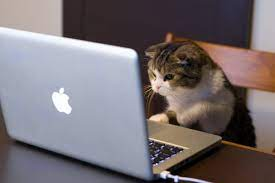


Item 1
{'type': 'TITLE', 'value': '"Knowledge Check"'}


Item 2
{'type': 'MULTIPLE_CHOICE', 'value': {'question': '"\n\n Which line of code in the is responsible for creating a new instance of the Flask class and assigning it to the variable \'app\'?\n\n"', 'answers': [{'frozen': 'false', 'correct': 'true', 'answerText': '"\n<p>\n app = Flask(name)\n</p>\n"', 'pageItemId': '623660', 'globalAnswerId': 'null', 'explanation': 'null', 'id': '876785', 'modified': 'false', 'longId': '876785', 'idName': '"id"', 'compositeKeys': 'null', 'valid': 'true', 'new': 'false'}, {'frozen': 'false', 'correct': 'false', 'answerText': '"\n<p>\n from flask import Flask\n</p>\n"', 'pageItemId': '623660', 'globalAnswerId': 'null', 'explanation': 'null', 'id': '876786', 'modified': 'false', 'longId': '876786', 'idName': '"id"', 'compositeKeys': 'null', 'valid': 'true', 'new': 'false'}, {'frozen': 'false', 'correct': 'false', 'answerText': '"\n<p>\n app.run(debug=True)\n</p>\n"', 'pageItemId': '623660', 'glob


Item 2
{'type': 'TEXT', 'value': {'text': ['"', 'MVC Map Reminder', 'Databases Overview', 'Databases are a way to store information', 'The amount of data we produce every day is truly mind-blowing.', '2.5 quintillion bytes', '/ day', 'in late 2021', '20,000,000,000,000,000,000', '1s and 0s', 'Over the last two years alone, >90 percent of the data in the world was generated!', 'So why do you need databases?', 'When you quit your Python program all the objects will be', 'deleted', '.', 'Databases are a', 'way to store information', 'even after you stop your program from running.', 'Databases help us retrieve information dynamically when a user is interacting with it!', 'Ex: Facebook profile', 'What is a database?', 'A', 'database', 'is a lot of tables.', 'These tables might look something like this.', 'Column 1 (id*)', 'Column 2', 'Column 3', '...', 'Column N', 'Table entry (1)', 'Table entry (2)', 'Table entry (3)', '...', 'Table entry (M)', 'This is an example Python', 'User', 'Class'


Item 4
{'type': 'TEXT', 'value': {'text': ['"', 'APP ADJECTIVES:', 'The', 'look', 'and', 'feel', 'of apps', 'EXAMPLE: THE NEW YORK TIMES', 'Simple, sleek, not busy, established, historicu200b', 'Black and white makes it seem like print, newspaper, trustworthy', 'Font - classic typefaceu200b', 'EXAMPLE: CATAN AND WORDSCAPES', 'Playful, not seriousu200b', 'Not concerned with professional u200b', 'Animated images u200b', 'Colorful! Location of colors is importantu200b', 'EXAMPLE: INSTAGRAM', 'Endless scroll - keeping people on the appu200b', 'Putting content front and centeru200b', 'Minimal u200b', 'Logo - cursive font, playfulu200b', 'Black fontsu200b', 'Square images = polaroid queues', 'HOW TO ADD BRANDING TO YOUR WEBSITE', 'Location of elements on the screenu200b', 'Color paletteu200b', 'Fonts', 'Logos, Icons & Imagesu200b', 'A/B Testing', '"'], 'images': ['https://lh4.googleusercontent.com/0hv1-ilg6lJ0uhFcvudW5FH66l1vgUhfDnlUlBO5PjJZizz7aitshV3HPtUiCEjcpv_T3cxJNPpetrCdVrq5TiHj_nekYB

In [188]:
for path in all_files:
    lesson = path.split("/")[-2]
    page = path.split("/")[-1].split(".")[0]
    print("*"*89)
    print(lesson)
    print(page)
    print("*"*89)
    
    with open(path, 'r') as file:
        html_content = file.read()
        
    pageItems_string = html_content.split('"pageItems":[')[1].rsplit("]", maxsplit=1)[0]
    
    pageItems = parse_nested_braces(pageItems_string)
    pageItems = [parse_key_value_pairs(pi) for pi in pageItems]
    
    for i, pageItem in enumerate(pageItems):
        pi = parse_item(pageItem)
        print()
        print(f"Item {i+1}")
        print(pi)
        print()
    print()
    